# Analisi del dataset dell'attrattore di Lorenz
La **rilevazione di anomalie** mediante riduzione della dimensionalità si basa sull'assunto che i dati abbiano variabili correlate tra loro e che possano essere incorporati in un sottospazio di dimensione inferiore in cui campioni normali e campioni anomali appaiono significativamente diversi.<br>
Abbiamo usato i seguenti algoritmi sul dataset:
* PCA
* Kernel PCA
* Sparse Autoencoder
* Denoising Autoencoder

Per distinguere le anomalie dai dati normali si definisce l'errore di ricostruzione.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from path import Path
from sklearn.model_selection import train_test_split
from lib.autoencoder import AutoEncoder
from numpy import linalg as LA
import lib.noisy as noisy
import tensorflow as tf
from pylab import rcParams
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [2]:
plt.style.use('ggplot')
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
#RANDOM_SEED = 42
np.random.seed(14825)
tf.random.set_random_seed(14825)
LABELS = ["Normal", "Anomalous"]
PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
df = pd.read_csv(DATA_DIR / 'lorenz_system_std.csv' )

## Reconstruction error
Per distinguere le anomalie dai dati normali si definisce l'errore di ricostruzione, nella fase di training, supponiamo che $ \{\mathit{\mathbf{x}}(1), \mathit{\mathbf{x}}(2), \dots, \mathit{\mathbf{x}}(m)\}$ siano i dati normali del nostro training set e che ciascun campione $\mathit{\mathbf{x}}(i)\in\mathbb{R}^D$ sia rappresentato da un vettore di $D$ variabili differenti. Comprimendo i dati in un sottospazio latente con dimensione inferiore si ottiene l'output $ \{\hat{\mathbf{x}}(1), \hat{\mathbf{x}}(2), \dots, \hat{\mathbf{x}}(m)\}$ che minimizza l'errore di ricostruzione così definito:


$$Err(i) = \sqrt{\frac{\sum_{j=1}^D (x_j(i)-\hat{x}_j(i))^2}{n}}$$

Durante la fase di test, si proiettano i dati del test set nel sottospazio e ricostruiamo il dato originale usando l'errore di ricostruzione per rilevare le anomalie: i dati con errore di ricostruzione più alto saranno considerati anomali.


In [3]:
def reconstruction_error(X, Y):
    return np.power(np.mean(np.power(X - Y, 2), axis=1),1/2)

Le serie temporali generate dal sistema di Lorenz sono state trasposte in verticale. Si procede alla divisione di test set e training set senza eseguire un rimescolamento dei record per preservare l'ordine temporale. 

In [4]:
y_train = df.loc[:int(df.shape[0]*0.7),'label'].values
y_test = df.loc[int(df.shape[0]*0.7):,'label'].values
X_train = df.loc[:int(df.shape[0]*0.7), '0':'24'].values
X_test = df.loc[int(df.shape[0]*0.7):,'0':'24'].values

In [5]:
df.head()

0         1         2         3         4         5         6  \
0 -1.431767  2.103014 -1.270776 -2.211933  2.469862 -0.174721 -1.063431   
1 -0.702031  0.427567  0.200698  0.742089 -0.226772  1.060183  1.057849   
2 -0.317380  0.067802  0.684884  0.674758 -0.593654  0.927222  0.919140   
3 -0.568916  0.220802  0.577478  0.958449 -0.593755  1.218408  1.250884   
4 -0.596021  0.385793  0.264988  0.549013 -0.195369  0.919155  0.871932   

          7         8         9  ...        16        17        18        19  \
0  0.638565  2.069887  2.650391  ... -2.326216 -1.337679  1.716443  0.607949   
1  0.957609 -0.841970 -0.476606  ...  0.734817 -0.789919 -0.964312  0.966291   
2  0.776050 -0.785510 -0.602859  ...  0.736819 -0.522707 -0.895026  0.732145   
3  1.030558 -1.079810 -0.766517  ...  0.994474 -0.747286 -1.205625  1.012177   
4  0.850833 -0.650300 -0.342952  ...  0.557409 -0.706517 -0.775356  0.841627   

         20        21        22        23        24  label  
0 -1.940073 -0.364869  2.548668  1.099904 -1.850415      0  
1  0.912032  1.072669 -0.207645 -1.057131  0.559530      0  
2  0.896722  0.901445 -0.226747 -1.005731  0.915365      0  
3  1.182916  1.219817 -0.373868 -1.301827  0.964528      0  
4  0.732788  0.909889 -0.070692 -0.895449  0.525902      0  

[5 rows x 26 columns]

In [6]:
df.describe()

0             1             2             3             4  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean  -7.838175e-17 -9.681145e-17 -8.604228e-18 -2.506606e-16  1.313949e-16   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -2.763913e+00 -2.509699e+00 -2.550105e+00 -2.655342e+00 -3.489312e+00   
25%   -6.411931e-01 -7.006084e-01 -6.624604e-01 -7.341860e-01 -6.268971e-01   
50%    4.673838e-02  9.460658e-03 -2.579817e-01 -1.831486e-02  1.115412e-01   
75%    6.640198e-01  7.665437e-01  4.768903e-01  7.407486e-01  7.222036e-01   
max    2.701973e+00  2.651177e+00  3.915955e+00  2.474895e+00  2.469862e+00   

                  5             6             7             8             9  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean  -3.108624e-17 -1.776357e-18  3.508305e-17  1.335043e-16  2.231548e-16   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -2.274121e+00 -2.456946e+00 -2.597489e+00 -2.585727e+00 -2.662552e+00   
25%   -6.528130e-01 -6.149046e-01 -5.905912e-01 -6.843163e-01 -7.499172e-01   
50%   -3.272757e-02 -6.625559e-03  5.857196e-02 -4.980572e-03  5.833615e-02   
75%    6.270029e-01  5.498016e-01  6.852909e-01  7.272097e-01  7.627499e-01   
max    2.328509e+00  2.727110e+00  2.105871e+00  2.612460e+00  2.650391e+00   

       ...            16            17            18            19  \
count  ...  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean   ...  1.742217e-16 -1.476597e-16 -2.863265e-16  7.838175e-17   
std    ...  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min    ... -2.469480e+00 -2.375322e+00 -2.702784e+00 -2.638738e+00   
25%    ... -7.510947e-01 -6.677078e-01 -6.189110e-01 -5.797788e-01   
50%    ... -2.509179e-02 -4.030362e-02 -1.132614e-02  1.656117e-02   
75%    ...  7.358908e-01  5.886376e-01  6.788860e-01  6.524861e-01   
max    ...  2.510904e+00  2.739377e+00  2.526488e+00  2.275485e+00   

                 20            21            22            23            24  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean   2.453593e-17  6.239453e-17 -3.306244e-16 -6.639134e-17  1.043610e-16   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -2.433055e+00 -2.266683e+00 -3.439119e+00 -2.684647e+00 -2.445977e+00   
25%   -6.977112e-01 -6.144869e-01 -6.635234e-01 -5.699170e-01 -5.897118e-01   
50%   -6.925269e-03 -4.764748e-02  8.506474e-02  8.802621e-02 -3.459830e-01   
75%    5.828615e-01  5.922880e-01  7.212026e-01  6.666135e-01  3.840440e-01   
max    2.730599e+00  2.533452e+00  2.548668e+00  2.231530e+00  3.986396e+00   

            label  
count  1000.00000  
mean      0.15000  
std       0.35725  
min       0.00000  
25%       0.00000  
50%       0.00000  
75%       0.00000  
max       1.00000  

[8 rows x 26 columns]

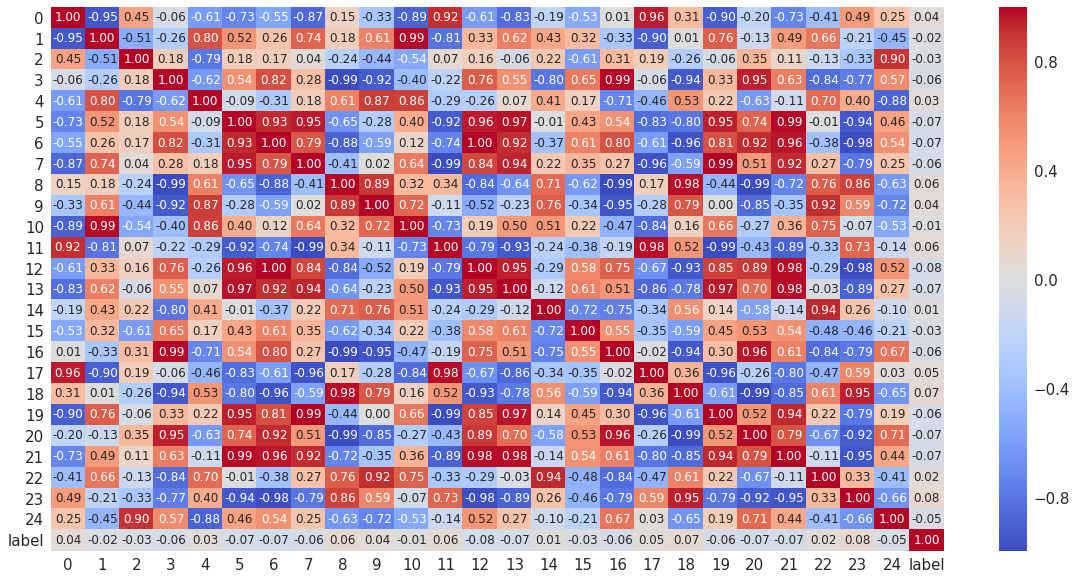

In [7]:
corr_matrix = df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(data=corr_matrix, cmap='coolwarm',annot=True, fmt=".2f", annot_kws={'size':12} )

# Anomaly detection con la PCA lineare
>Seguendo quello che è stato riportato in [1], applichiamo la PCA ai dati generati artificialmente. 
In [1] vengono individuate 10 componenti principali

In [8]:
PCA = PCA(n_components=10)
PCA.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [9]:
X_test_pca = PCA.transform(X_test)
X_projected_test = PCA.inverse_transform(X_test_pca)

In [10]:
error_e_test = np.power(np.mean(np.power(X_test - X_projected_test, 2), axis=1), 1/2)

>Come in [1], si raffigura l'errore di ricostruzione sul test set. I picchi rappresentano le anomalie

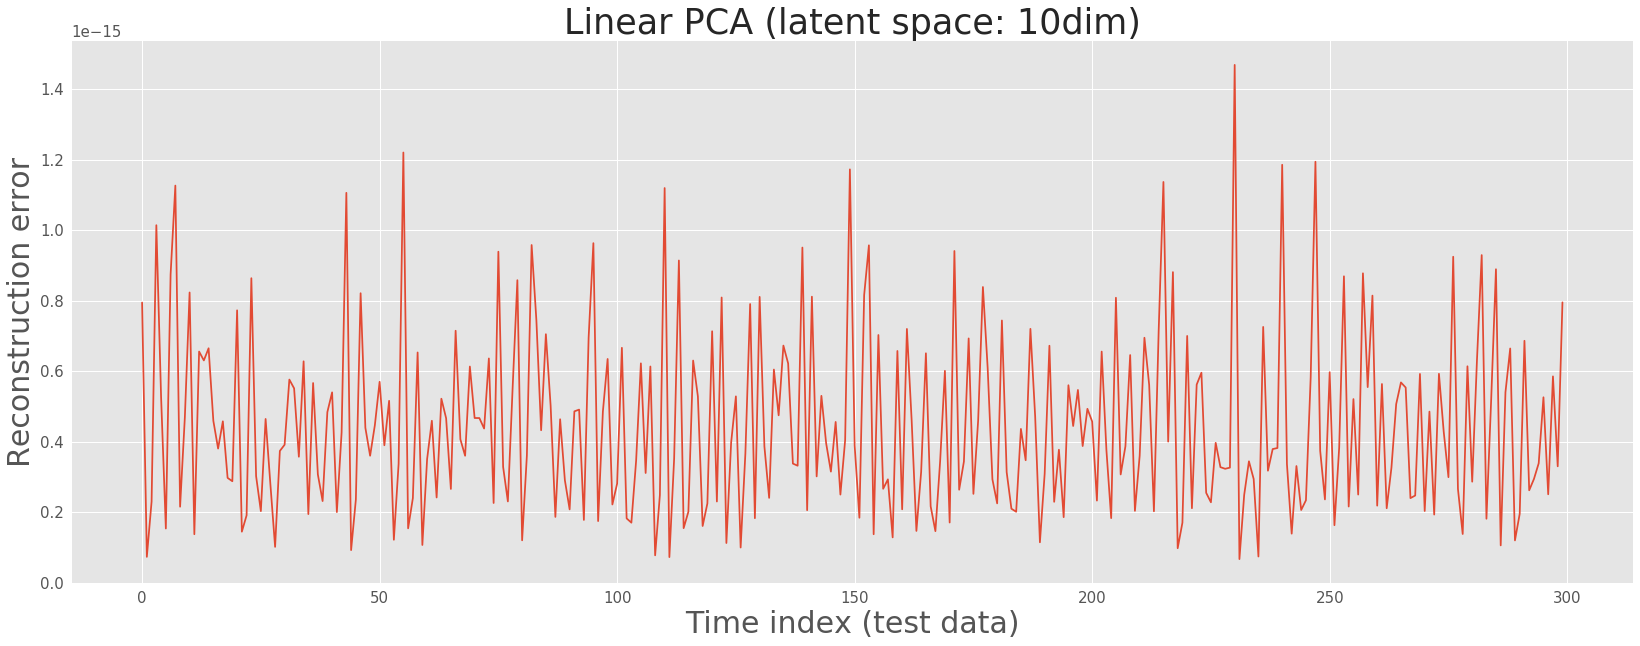

In [11]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(error_e_test)
    plt.title('Linear PCA (latent space: 10dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Reconstruction error', size=30)

>Si raffigurano le differenze tra il dato originale e quello ricostruito 

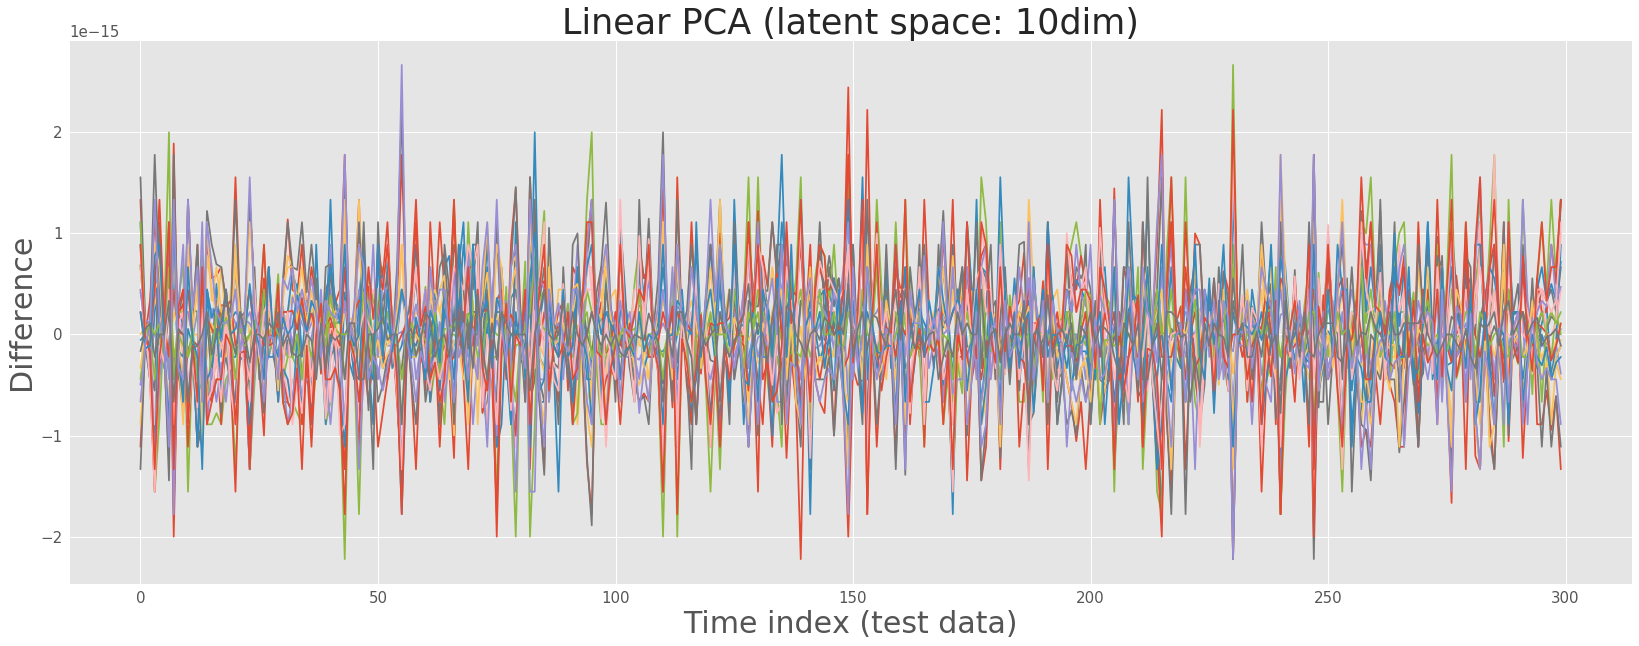

In [12]:
X=X_projected_test.T
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    for i in np.arange(0,25):
        plt.plot(np.arange(300), X_test.T[i,:]-X[i,:])
    plt.title('Linear PCA (latent space: 10dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Difference', size=30)

In [13]:
rmse_pca = reconstruction_error(X_test, X_projected_test)
error_df_pca = pd.DataFrame({'reconstruction_error': rmse_pca,
                        'true_class': y_test})
error_df_pca.describe()

reconstruction_error  true_class
count          3.000000e+02  300.000000
mean           4.491861e-16    0.500000
std            2.607361e-16    0.500835
min            6.724644e-17    0.000000
25%            2.355684e-16    0.000000
50%            3.873701e-16    0.500000
75%            6.132295e-16    1.000000
max            1.468267e-15    1.000000

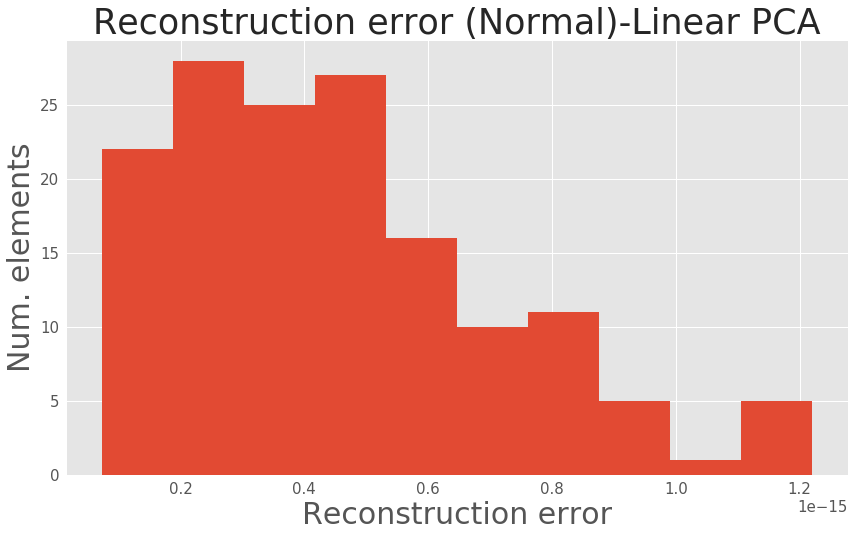

In [14]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    normal_error_df_pca = error_df_pca[(error_df_pca['true_class']== 0) & (error_df_pca['reconstruction_error'] < 10)]
    _ = ax.hist(normal_error_df_pca.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Normal)-Linear PCA', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

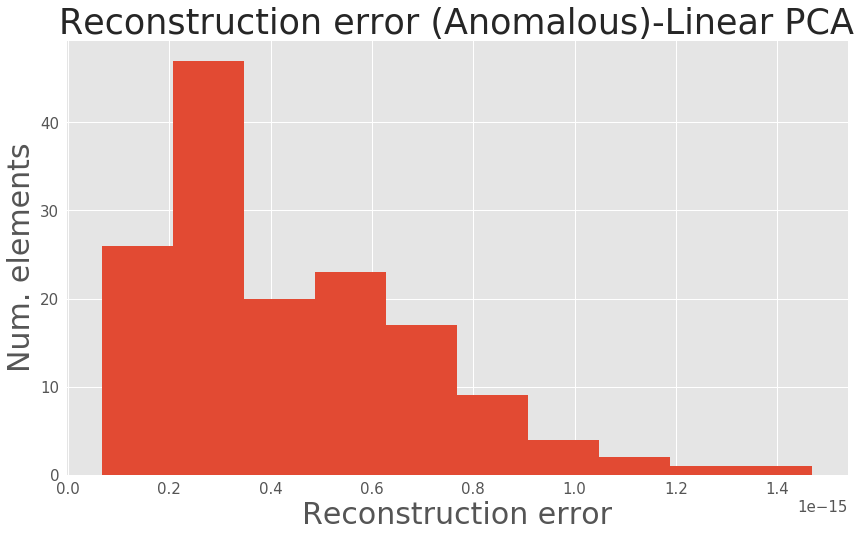

In [15]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    anom_error_df_pca = error_df_pca[error_df_pca['true_class'] == 1]
    _ = ax.hist(anom_error_df_pca.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Anomalous)-Linear PCA', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

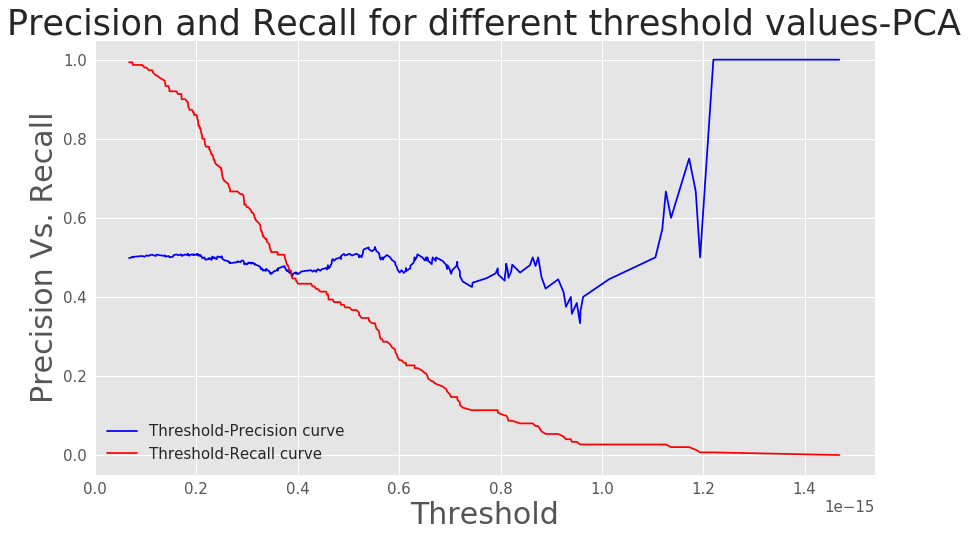

In [16]:
precision_pca, recall_pca, th_pca = precision_recall_curve(error_df_pca.true_class, error_df_pca.reconstruction_error)
with plt.style.context('ggplot'):
    plt.plot(th_pca, precision_pca[1:], 'b', label='Threshold-Precision curve')
    plt.plot(th_pca, recall_pca[1:], 'r', label='Threshold-Recall curve')
    plt.title('Precision and Recall for different threshold values-PCA', size = 35)
    plt.xlabel('Threshold', size = 30)
    plt.ylabel('Precision Vs. Recall', size = 30)
    plt.legend(loc='best')

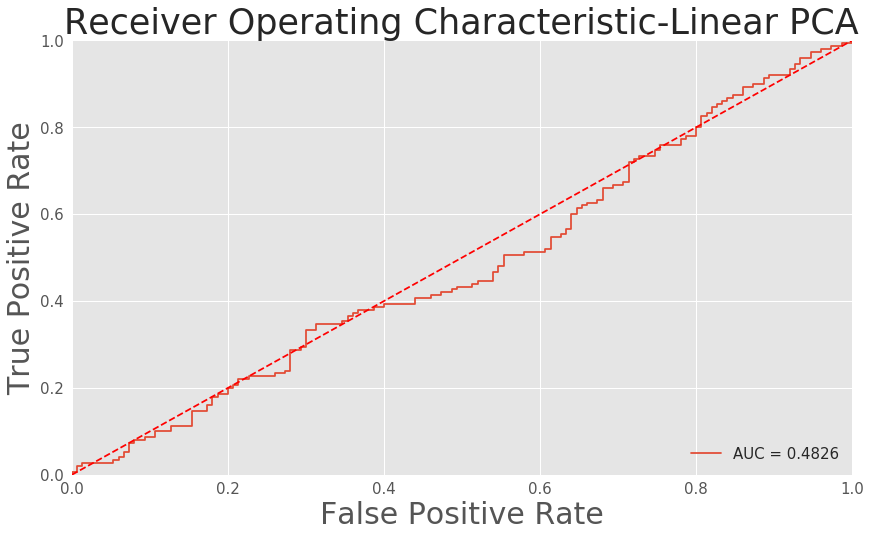

In [17]:
fpr_pca, tpr_pca, thresholds_pca = roc_curve(error_df_pca.true_class, error_df_pca.reconstruction_error)
roc_auc_pca = auc(fpr_pca, tpr_pca)
with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic-Linear PCA', size=35)
    plt.plot(fpr_pca, tpr_pca, label='AUC = %0.4f'% roc_auc_pca)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size=30)
    plt.xlabel('False Positive Rate', size=30)


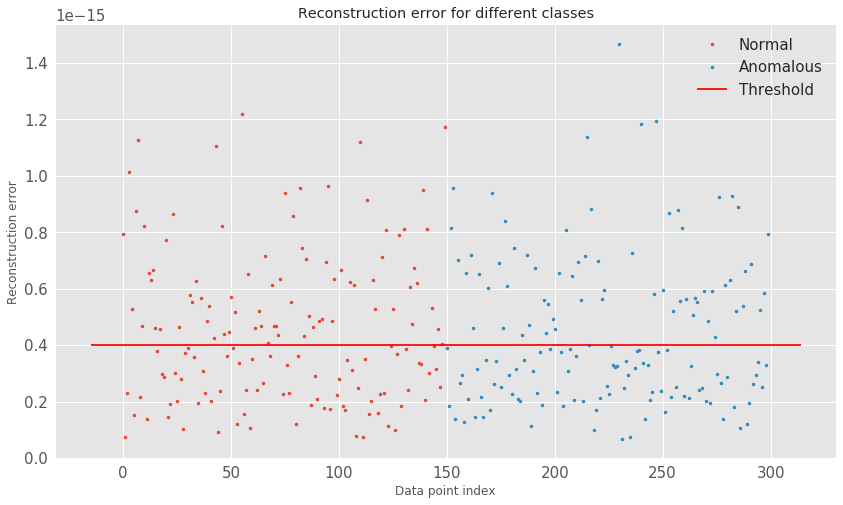

In [18]:
threshold = 0.4*10**(-15)#0.4*10**(-15)
groups = error_df_pca.groupby('true_class')
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Anomalous" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")

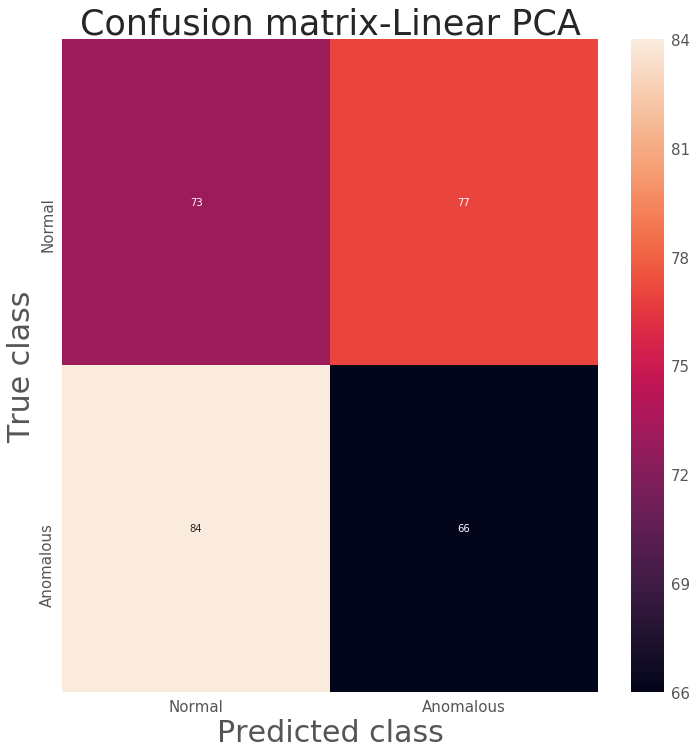

In [19]:
y_pred_pca = [1 if e > threshold else 0 for e in error_df_pca.reconstruction_error.values]
conf_matrix_pca = confusion_matrix(error_df_pca.true_class, y_pred_pca)
with plt.style.context('ggplot'):
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix_pca, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix-Linear PCA", size = 35)
    plt.ylabel('True class', size = 30)
    plt.xlabel('Predicted class', size = 30)
    


# Anomaly detection con la kernel PCA

>Seguendo quello che è stato riportato in [1], applichiamo la Kernel PCA ai dati generati artificialmente.
>In [1], viene addestrata una Kernel PCA con un numero di componenti pari a 10 e con la funzione kernel *Radial Basis Function (o gaussiana)* definita come:

$$k(\mathbf{x}(i), \mathbf{x}(j))=\exp\biggl(-\frac{\Vert \mathbf{x}(i)-\mathbf{x}(j)\Vert^2}{\mathbf{\sigma}^2}\biggr)$$

In [20]:
KPCA = KernelPCA(n_components=10, kernel='rbf', fit_inverse_transform=True) #parametro per gamma

In [21]:
KPCA.fit(X_train)
X_test_kpca = KPCA.transform(X_test)
X_projected_test_kpca = KPCA.inverse_transform(X_test_kpca)
error_e_test = np.power(np.mean(np.power(X_test - X_projected_test_kpca, 2), axis=1), 1/2)

>Come in [1], si raffigura l'errore di ricostruzione sul test set. I picchi rappresentano le anomalie

## Analisi dell'errore di ricostruzione della Kernel PCA
Al contrario della PCA standard, questa volta notiamo che gli errori di ricostruzione più alti si trovano nella seconda metà del test set, dove si trovano i dati anomali, mentre i dati normali hanno un basso errore di ricostruzione.
Dagli istogrammi possiamo ossevare che la maggior parte dei dati Normali ha un errore di ricostruzione compreso tra 0 e 0.2, e ve ne sono pochi con un errore superiore. Tra i dati Anomali invece ve ne sono molti con errore superiore a 0.2.

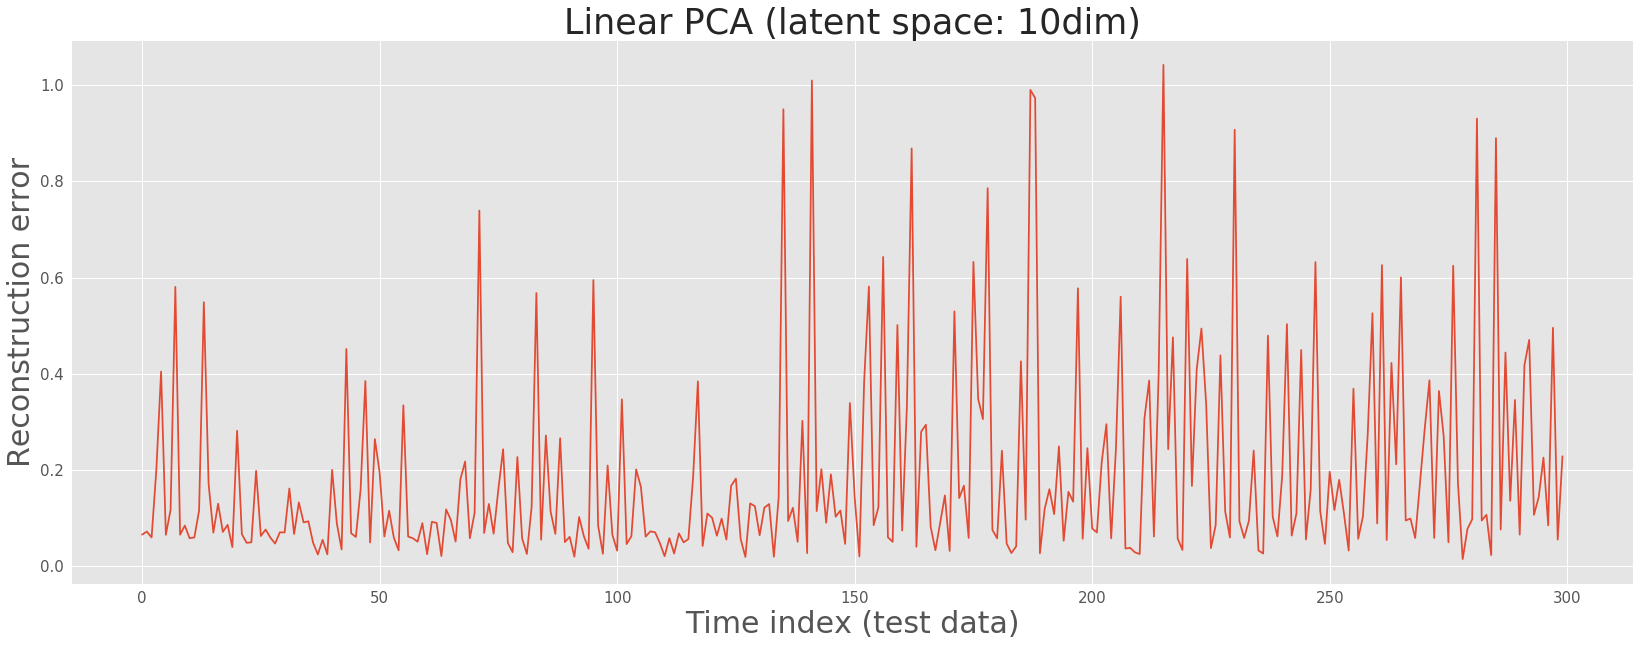

In [22]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(error_e_test)
    plt.title('Linear PCA (latent space: 10dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Reconstruction error', size=30)

>Si raffigurano le differenze tra il dato originale e quello ricostruito: 

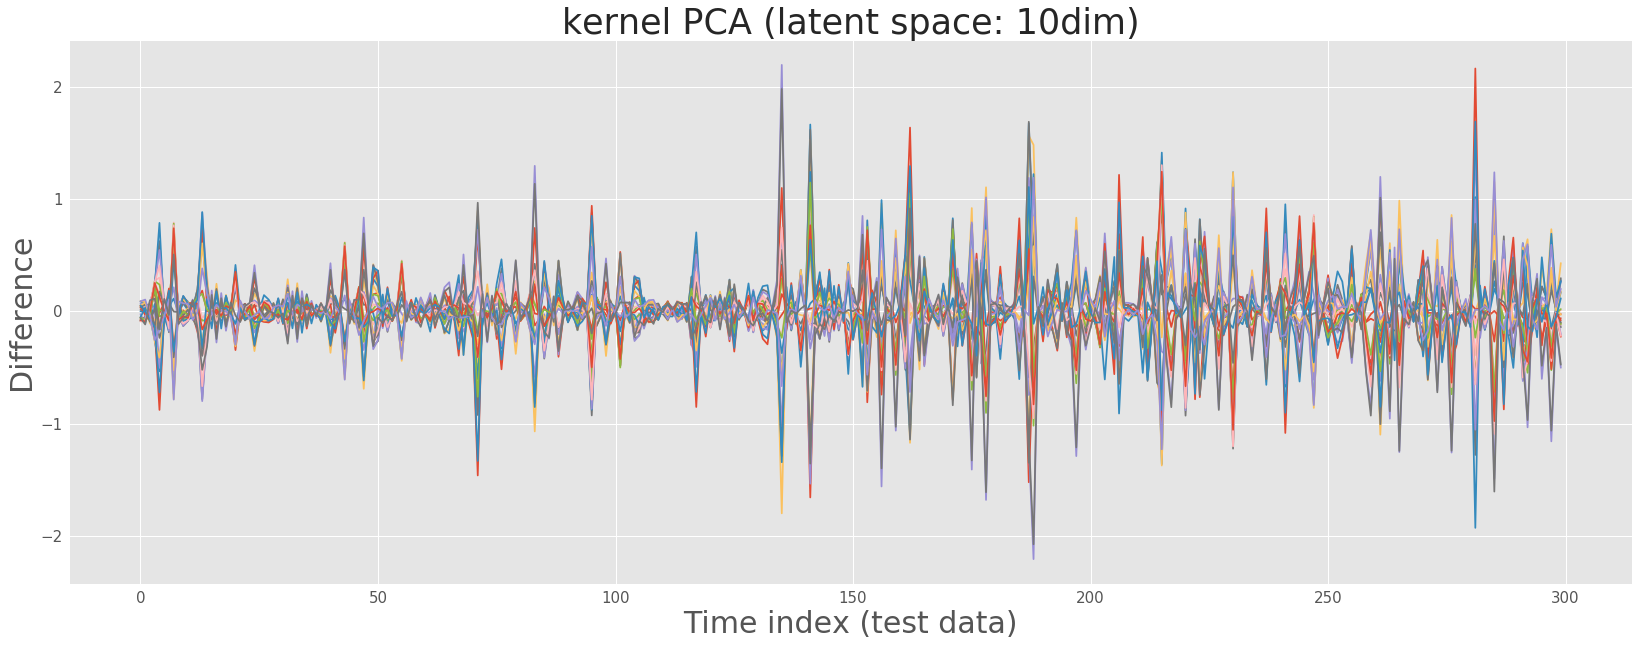

In [23]:
X= X_projected_test_kpca.T
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    for i in np.arange(0,25):
        plt.plot(np.arange(300), X_test.T[i,:]-X[i,:])
    plt.title('kernel PCA (latent space: 10dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Difference', size=30)

In [24]:
rmse_kpca = reconstruction_error(X_test, X_projected_test_kpca)
error_df_kpca = pd.DataFrame({'reconstruction_error': rmse_kpca,
                        'true_class': y_test})
error_df_kpca.describe()

reconstruction_error  true_class
count            300.000000  300.000000
mean               0.191337    0.500000
std                0.209348    0.500835
min                0.015323    0.000000
25%                0.059228    0.000000
50%                0.101902    0.500000
75%                0.243647    1.000000
max                1.041898    1.000000

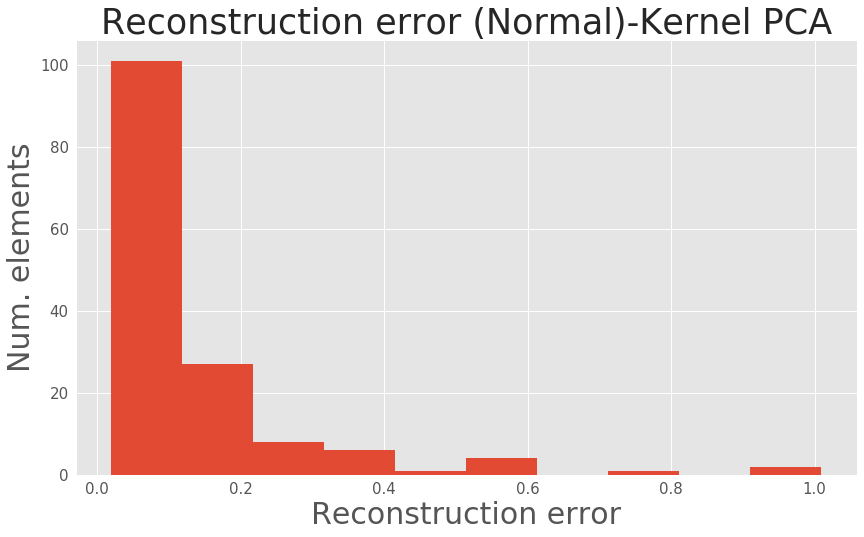

In [25]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    normal_error_df_kpca = error_df_kpca[(error_df_kpca['true_class']== 0) & (error_df_kpca['reconstruction_error'] < 3)]
    _ = ax.hist(normal_error_df_kpca.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Normal)-Kernel PCA', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

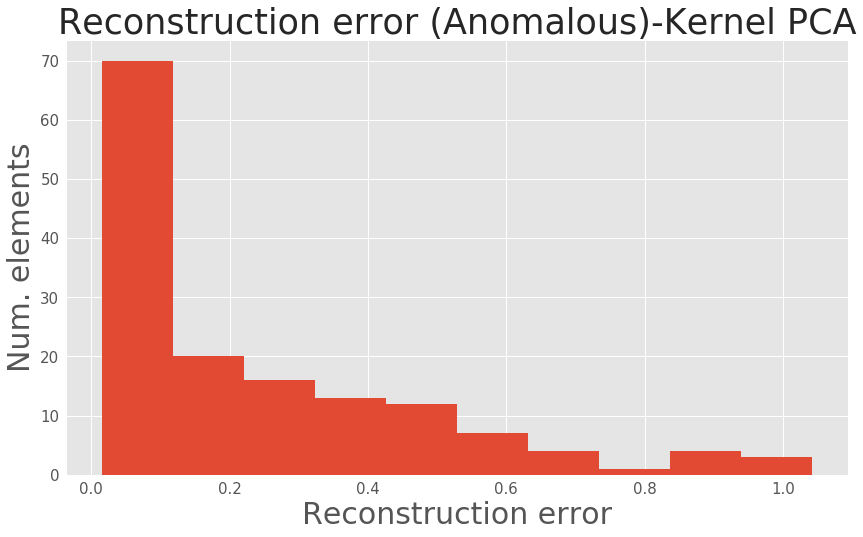

In [26]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    anom_error_df_kpca = error_df_kpca[error_df_kpca['true_class'] == 1]
    _ = ax.hist(anom_error_df_kpca.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Anomalous)-Kernel PCA', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

## Scelta del threshold per la classificazione e analisi della ROC e confusion matrix
Per cercare di identificare i dati anomali è possibile osservare l'errore di ricostruzione e classificare come anomali i dati il cui errore supera un certo threshold.
Nel grafico seguente mettiamo a confronto la variazione dei valori di Precision e Recall al variare del threshold. Naturalmente all'aumentare del threshold la Precision aumenta, mentre la Recall diminuisce, dunque un threshold ideale è al punto di incontro tra le due curve.
Poché preferiamo avere falsi positivi piuttosto che falsi negativi, poniamo un threshold leggermente più basso, in modo da avere una Recall più alta a discapito della Precision.<br>



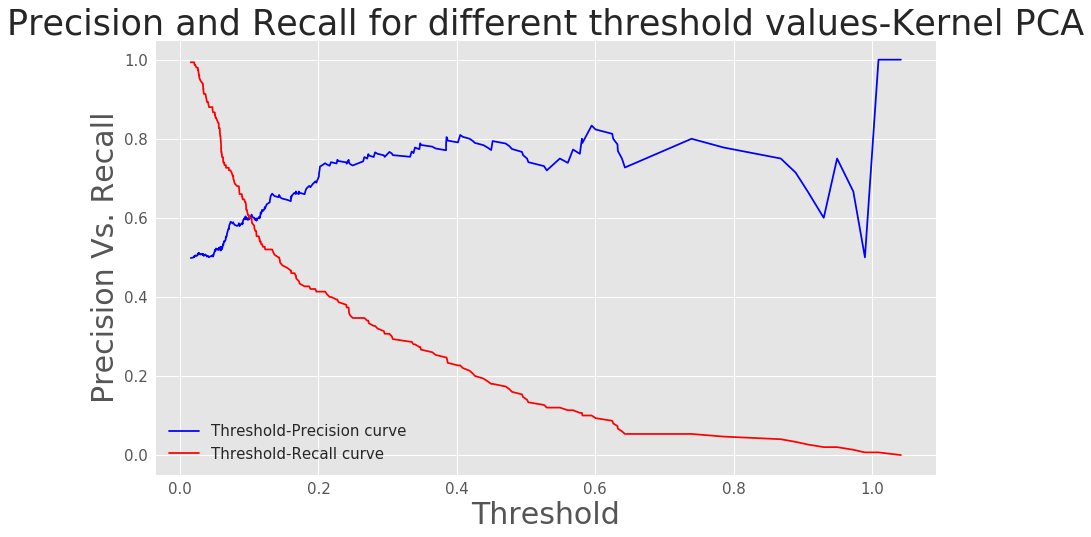

In [27]:
precision_kpca, recall_kpca, th_kpca = precision_recall_curve(error_df_kpca.true_class, error_df_kpca.reconstruction_error)
with plt.style.context('ggplot'):
    plt.plot(th_kpca, precision_kpca[1:], 'b', label='Threshold-Precision curve')
    plt.plot(th_kpca, recall_kpca[1:], 'r', label='Threshold-Recall curve')
    plt.title('Precision and Recall for different threshold values-Kernel PCA', size = 35)
    plt.xlabel('Threshold', size = 30)
    plt.ylabel('Precision Vs. Recall', size = 30)
    plt.legend(loc='best')

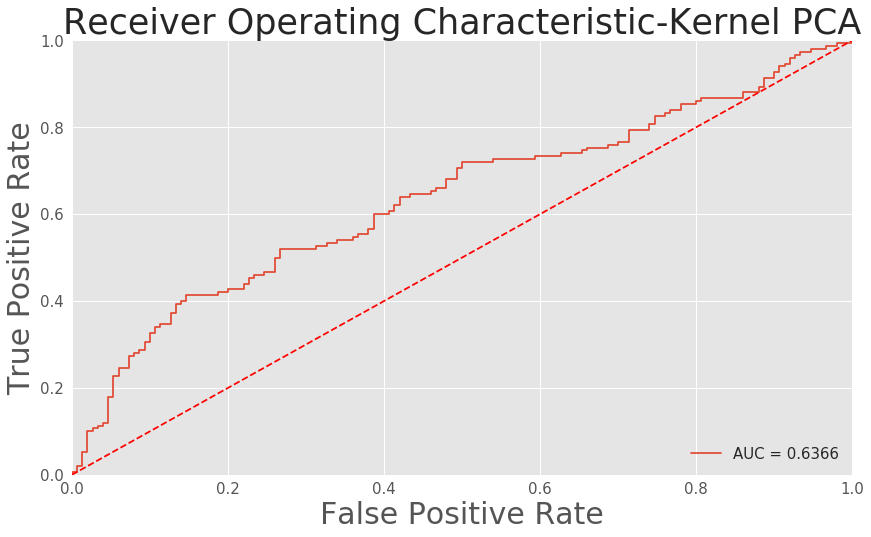

In [28]:
fpr_kpca, tpr_kpca, thresholds_kpca = roc_curve(error_df_kpca.true_class, error_df_kpca.reconstruction_error)
roc_auc_kpca = auc(fpr_kpca, tpr_kpca)
with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic-Kernel PCA', size=35)
    plt.plot(fpr_kpca, tpr_kpca, label='AUC = %0.4f'% roc_auc_kpca)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size=30)
    plt.xlabel('False Positive Rate', size=30)

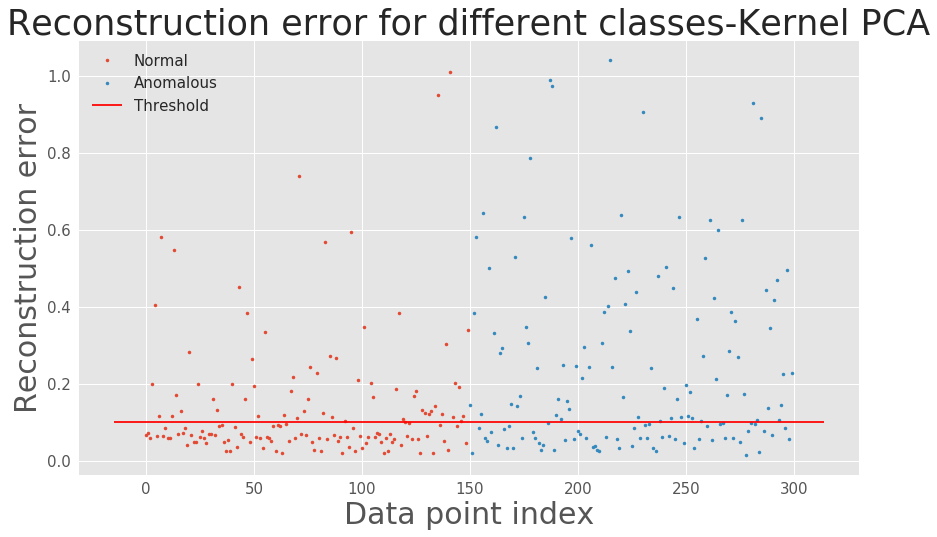

In [29]:
threshold = 0.1 #0.14 #0.13 (other values)
groups_kpca = error_df_kpca.groupby('true_class')
with plt.style.context('ggplot'):
    fig, ax = plt.subplots()
    for name, group in groups_kpca:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Anomalous" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes-Kernel PCA", size = 35)
    plt.ylabel("Reconstruction error", size = 30)
    plt.xlabel("Data point index", size = 30)

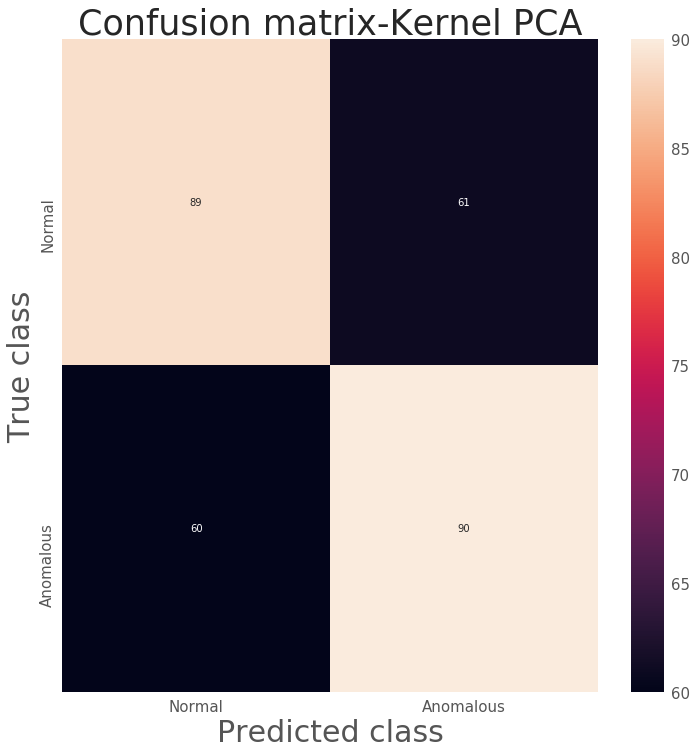

In [30]:
y_pred_kpca = [1 if e > threshold else 0 for e in error_df_kpca.reconstruction_error.values]
conf_matrix_kpca = confusion_matrix(error_df_kpca.true_class, y_pred_kpca)
with plt.style.context('ggplot'):
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix_kpca, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix-Kernel PCA", size = 35)
    plt.ylabel('True class', size = 30)
    plt.xlabel('Predicted class', size = 30)



# Anomaly Detection con l'autoencoder sottocompleto sparso
Un autoencoder è una rete neurale non supervisionata con l'obiettivo di imparare a riprodurre un vettore in input $\{\mathit{\mathbf{x}}(1), \mathit{\mathbf{x}}(2), \dots, \mathit{\mathbf{x}}(m)\}$ come output $ \{\hat{\mathbf{x}}(1), \hat{\mathbf{x}}(2), \dots, \hat{\mathbf{x}}(m)\}$. Nella figura sottostante viene schematizzato un autoencoder.

<img src="https://d3i71xaburhd42.cloudfront.net/ee70341e75c2dffebbabd24b239cc158ad691ed1/2-Figure1-1.png" alt="Autoencoder [1]">

<br>

In Figura, il Layer $L_2$ è l'*hidden layer* che comprime l'input con un numero limitato di neuroni.<br>
La funzione di attivazione (funzione per il calcolo dei pesi) di una unità $i$ nel layer $l$ è data dalla seguente:

$$a_i^{(l)}=f\biggl(\sum_{j=1}^n W_{i,j}^{(l-1)}a_{j}^{(l-1)}+b_{i}^{(l-1)}\biggr)$$

dove $\mathbf{W}$ denota il peso e $\mathbf{b}=\mathbf{1}$.<br> Nel primo layer (quello di input) $\mathbf{a}^{(1)}=\mathbf{x}$ mentre nell'ultimo layer (quello di output) $\mathbf{a}^{(1)}=\hat{\mathbf{x}}$.<br>
Come funzione di attivazione $f$ gli autori del paper M. Sakurada e T. Yairie per l'hidden layer usano la funzione sigmoide, noi invece dopo diverse prove abbiamo ottenuto risultati superiori usando la funzione **rectified linear unit (ReLU)** definita come:

$$R(x)=max(0,x)$$

mentre per l'output della funzione decode abbiamo lasciato invariato come funzione di attivazione la funzione lineare.<br>
Per dovere di completezza postiamo le funzioni di attivazioni più usate nel contesto del deep learning.<br>

<img src = "https://www.researchgate.net/profile/Vivienne_Sze/publication/315667264/figure/fig3/AS:669951052496900@1536740186369/Various-forms-of-non-linear-activation-functions-Figure-adopted-from-Caffe-Tutorial.png" alt ="funzioni di attivazioni">

Durante il periodo di addestramento, minimizziamo la seguente funzione di obiettivo:

$$J(\mathbf{W}, \mathbf{b})=\frac{1}{m}\sum_{i=1}^m \biggl(\frac{1}{2}\Vert \mathbf{x}(i)-\hat{\mathbf{x}}(i)\Vert^2 \biggr) + \frac{\lambda}{2}\sum_{l=1}^{n_l-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_l-1} \biggl(W_{ij}^{(l)}\biggr)^2$$

dove $n_l$ denota il numero di layers nella rete e $s_l$ il numero di unità nel layer $L_2$. La formula include il termine di regolarizzazione e $\lambda$ determina il grado di regolarizzazione.<br>

>Seguendo quello che è scritto in [1], addestriamo un autoencoder con le caratteristiche appena descritte. La dimensione dell'hidden layer pari a 10, $\lambda=0.00001$ e la dimensione dell'input è pari a 25.


Come algoritmo di ottimizzazione abbiamo scelto di usare **Adam** 

In [31]:
AE = AutoEncoder(num_features=X_train.shape[1], num_latent_node = 10,activation_fun='relu',  lamda = 10**-5, min_delta = 0.0004, patience = 3)
AE.model_settings()
AE.setting_train_test_DS(X_train, X_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [32]:
history_AE = AE.fit(epochs=1000, shuffle= False).history

Train on 701 samples, validate on 300 samples
Epoch 1/1000
701/701 [==============================] - 0s 525us/sample - loss: 1.3559 - mean_squared_error: 1.3558 - val_loss: 1.1505 - val_mean_squared_error: 1.1504
Epoch 2/1000
701/701 [==============================] - 0s 80us/sample - loss: 1.0946 - mean_squared_error: 1.0945 - val_loss: 0.9501 - val_mean_squared_error: 0.9500
Epoch 3/1000
701/701 [==============================] - 0s 77us/sample - loss: 0.9113 - mean_squared_error: 0.9112 - val_loss: 0.8024 - val_mean_squared_error: 0.8023
Epoch 4/1000
701/701 [==============================] - 0s 76us/sample - loss: 0.7705 - mean_squared_error: 0.7704 - val_loss: 0.6844 - val_mean_squared_error: 0.6843
Epoch 5/1000
701/701 [==============================] - 0s 79us/sample - loss: 0.6524 - mean_squared_error: 0.6523 - val_loss: 0.5794 - val_mean_squared_error: 0.5793
Epoch 6/1000
701/701 [==============================] - 0s 77us/sample - loss: 0.5450 - mean_squared_error: 0.5449 - v

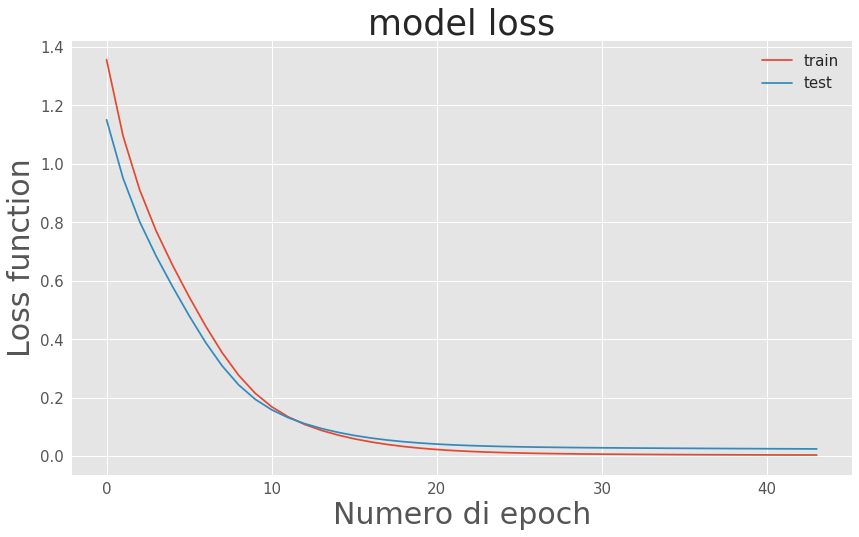

In [33]:
with plt.style.context('ggplot'):
    plt.plot(history_AE['loss'])
    plt.plot(history_AE['val_loss'])
    plt.title('model loss', size = 35)
    plt.ylabel('Loss function', size = 30)
    plt.xlabel('Numero di epoch', size = 30)
    plt.legend(['train', 'test'], loc='upper right')

In [34]:
AE.predict()

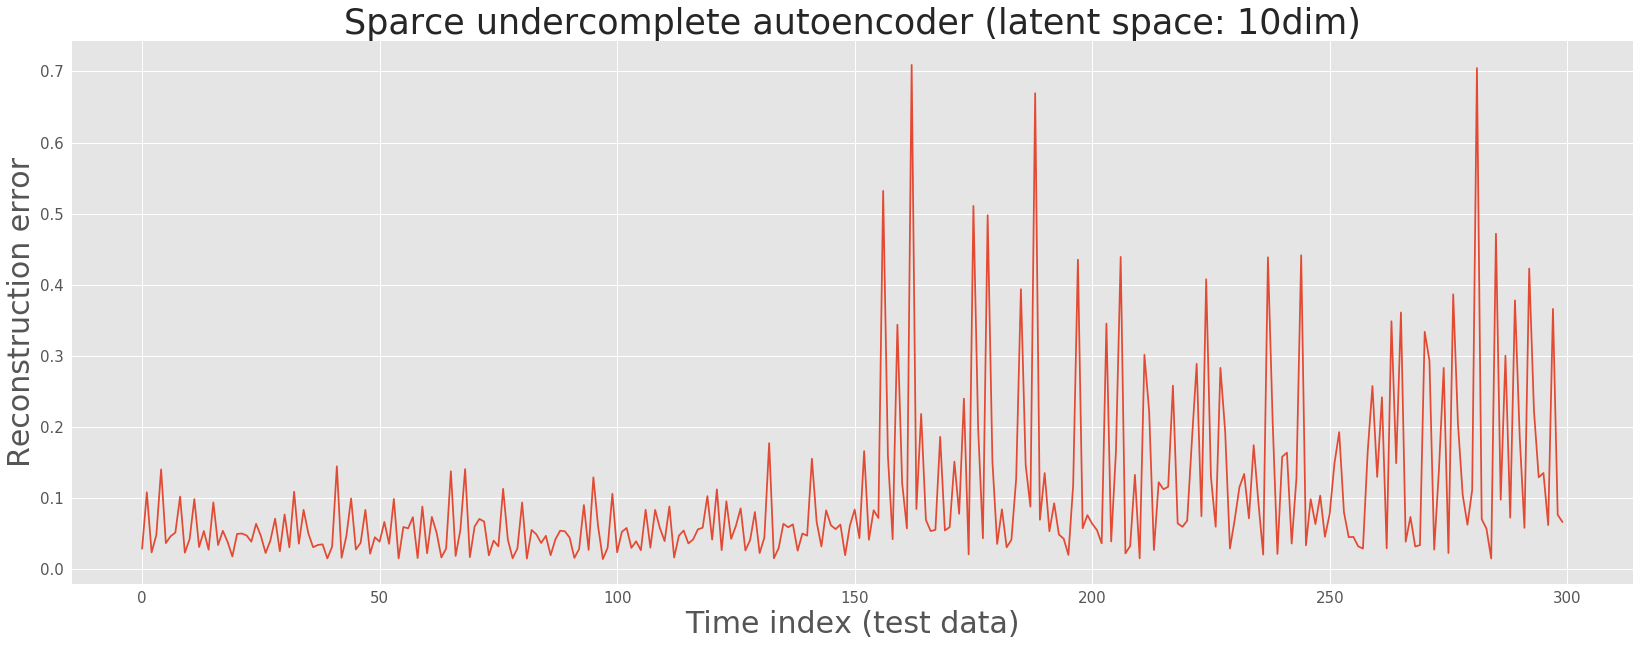

In [35]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(AE.get_error_recustruction_test())
    plt.title('Sparce undercomplete autoencoder (latent space: 10dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Reconstruction error', size=30)

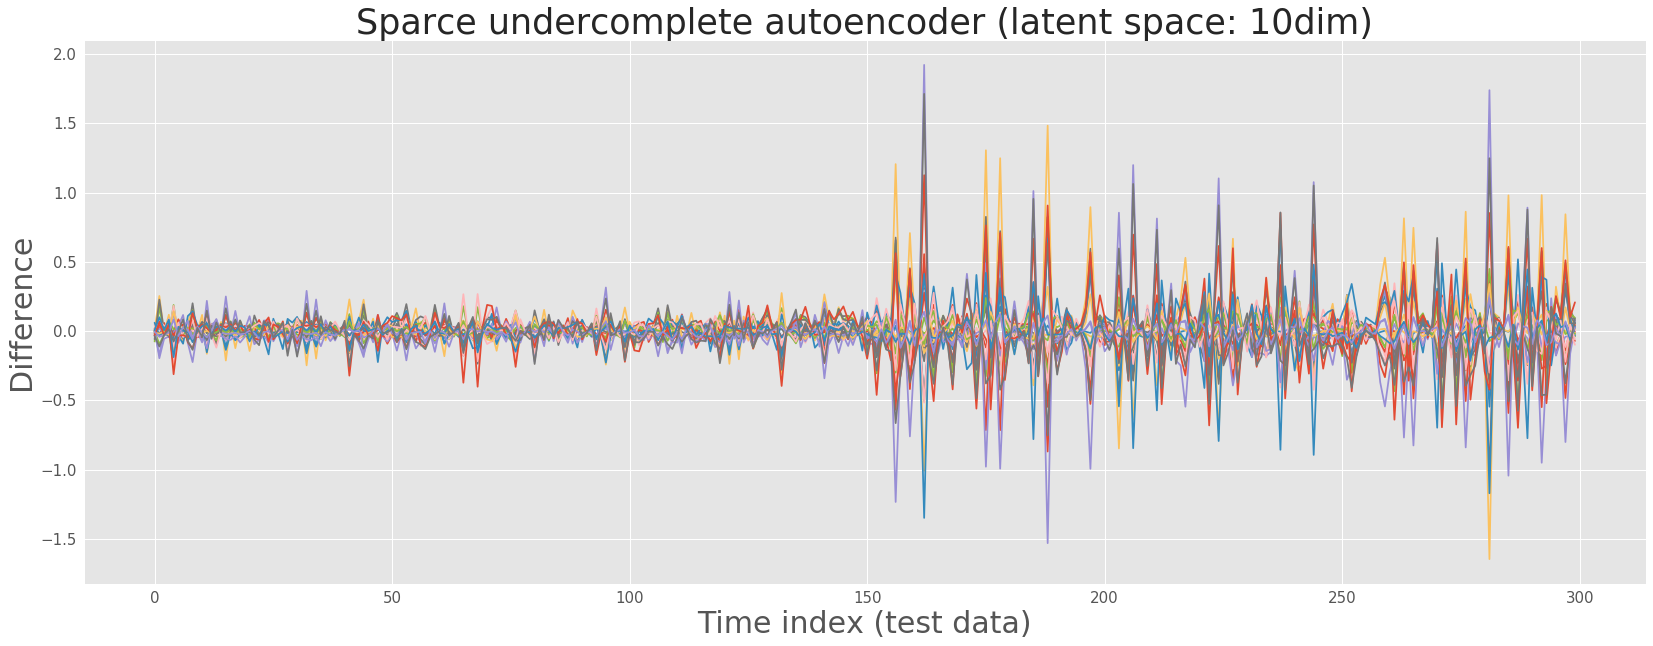

In [36]:
X=AE.X_test_hat.T
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    for i in np.arange(0,25):
        plt.plot(np.arange(300), X_test.T[i,:]-X[i,:])
    plt.title('Sparce undercomplete autoencoder (latent space: 10dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Difference', size=30)

In [37]:
rmse_AE = AE.get_error_recustruction_test()
error_df_AE = pd.DataFrame({'reconstruction_error': rmse_AE,
                        'true_class': y_test})
error_df_AE.describe()

reconstruction_error  true_class
count            300.000000  300.000000
mean               0.104388    0.500000
std                0.117642    0.500835
min                0.014326    0.000000
25%                0.036950    0.000000
50%                0.060028    0.500000
75%                0.116644    1.000000
max                0.709135    1.000000

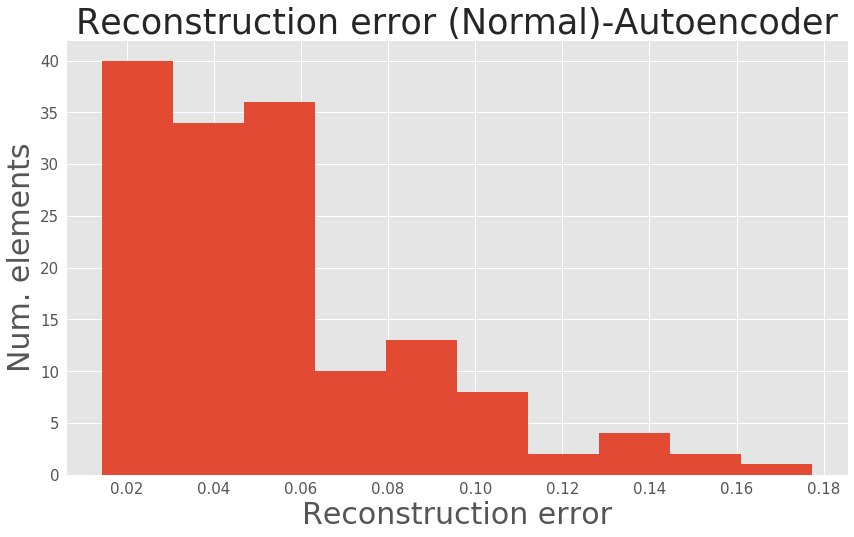

In [38]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    normal_error_df_AE = error_df_AE[(error_df_AE['true_class']== 0) & (error_df_AE['reconstruction_error'] < 10)]
    _ = ax.hist(normal_error_df_AE.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Normal)-Autoencoder', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

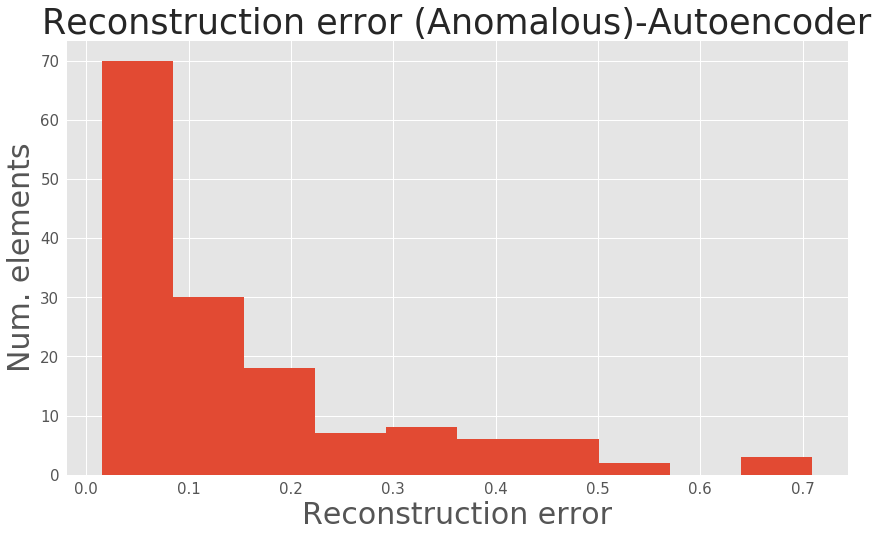

In [39]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fraud_error_df_AE = error_df_AE[error_df_AE['true_class'] == 1]
    _ = ax.hist(fraud_error_df_AE.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Anomalous)-Autoencoder', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

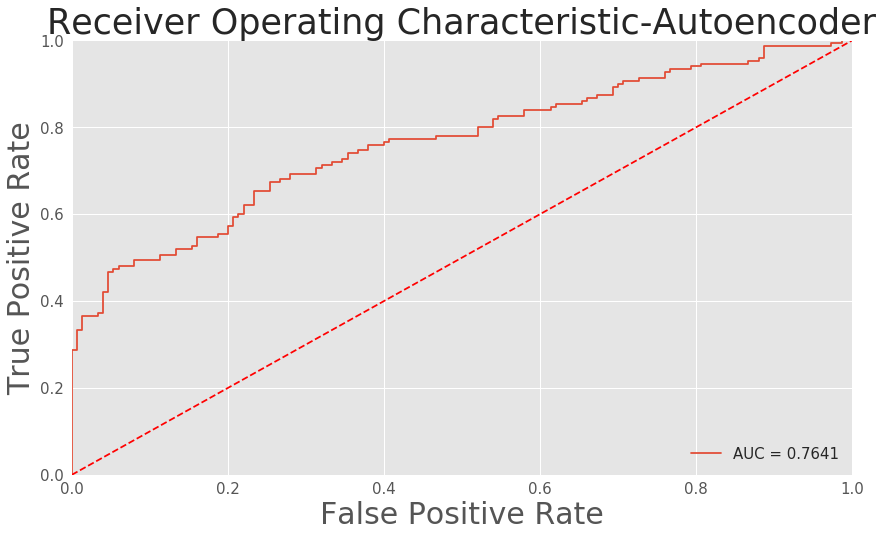

In [40]:
fpr_AE, tpr_AE, thresholds_AE = roc_curve(error_df_AE.true_class, error_df_AE.reconstruction_error)
roc_auc_AE = auc(fpr_AE, tpr_AE)
with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic-Autoencoder', size = 35)
    plt.plot(fpr_AE, tpr_AE, label='AUC = %0.4f'% roc_auc_AE)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size = 30)
    plt.xlabel('False Positive Rate', size = 30)


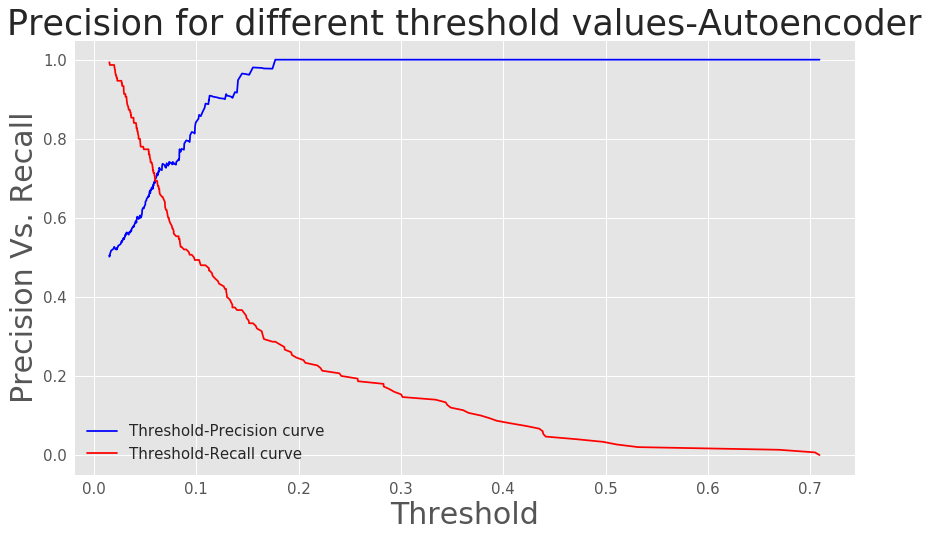

In [41]:
precision_AE, recall_AE, th_AE = precision_recall_curve(error_df_AE.true_class, error_df_AE.reconstruction_error)
with plt.style.context('ggplot'):
    plt.plot(th_AE, precision_AE[1:], 'b', label='Threshold-Precision curve')
    plt.plot(th_AE, recall_AE[1:], 'r', label='Threshold-Recall curve')
    plt.title('Precision for different threshold values-Autoencoder', size = 35)
    plt.xlabel('Threshold', size = 30)
    plt.ylabel('Precision Vs. Recall', size = 30)
    plt.legend(loc='best')
    

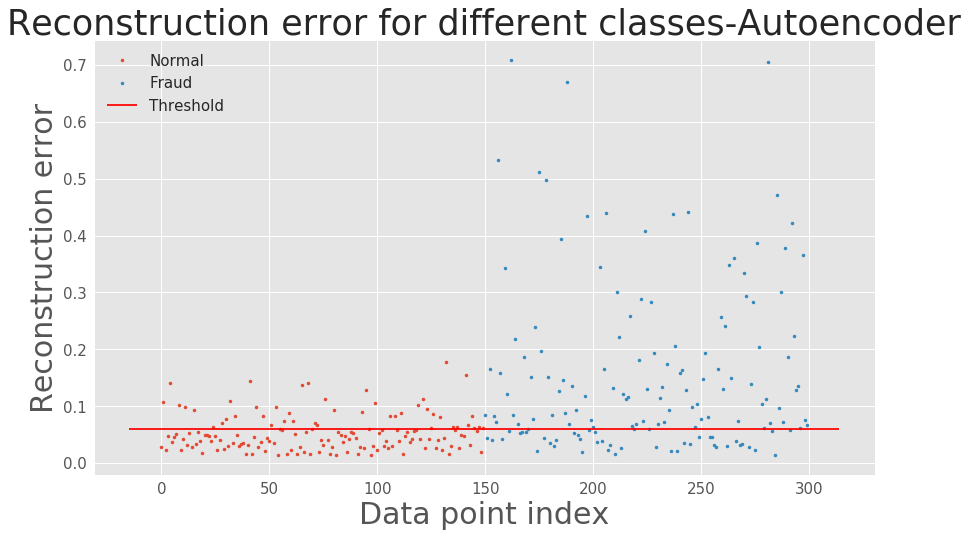

In [42]:
threshold = 0.06#0.1
with plt.style.context('ggplot'):
    groups_AE = error_df_AE.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups_AE:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Fraud" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes-Autoencoder", size = 35)
    plt.ylabel("Reconstruction error", size = 30)
    plt.xlabel("Data point index", size = 30)


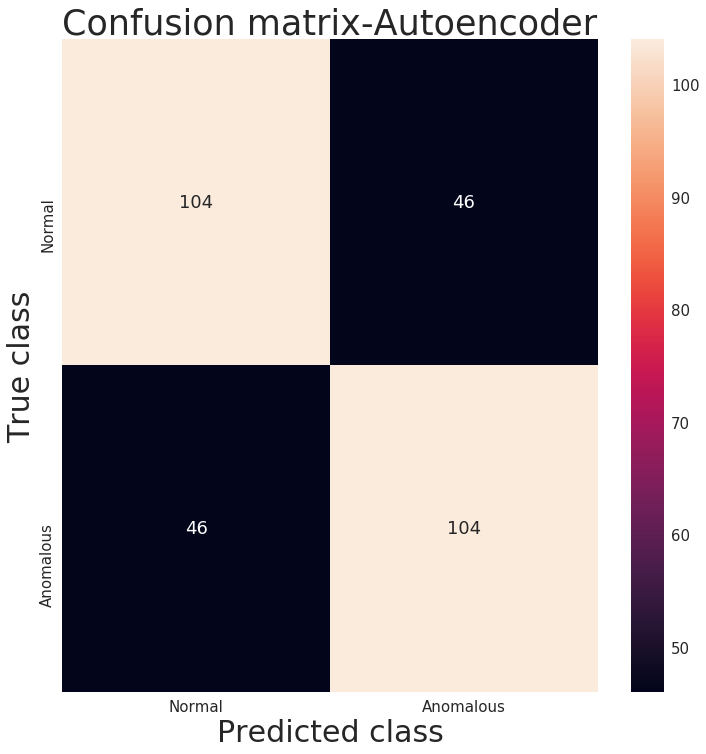

In [43]:
y_pred_AE = [1 if e > threshold else 0 for e in error_df_AE.reconstruction_error.values]
conf_matrix_AE = confusion_matrix(error_df_AE.true_class, y_pred_AE)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix_AE, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix-Autoencoder", size = 35)
plt.ylabel('True class', size = 30 )
plt.xlabel('Predicted class', size = 30)
plt.show()

# Anomaly detection con Denoising autoencoder
Un denoising autoencoder è un'estensione di un autoencoder che consente di catturare con più precisione le strutture e i modelli inerenti ai dati di input. A tale scopo aumentiamo il numero di neuroni nell'hidden layer e aggiungiamo un pò di rumore ai dati: un buon denoising autoencoder saprà riconoscere le anomalie anche in presenza di rumore.

La tecnica usata in [1] per aggiungere rumore ai dati prende il nome di salt-and-pepper e consiste nel porre uguale a zero un certo numero di componenti dell'input scelti casualmente, tuttavia questa tecnica non da risultati buoni per questo abbiamo abbiamo deciso di usare un rumore di tipo gaussiano N(0,1).

In [44]:
AE_denoising = AutoEncoder(num_features=25,num_latent_node=50, lamda = 10**-5, min_delta = 0.0004, patience = 10)
AE_denoising.model_settings()
X_train_noise = noisy.noisy("gauss" ,X_train)
AE_denoising.setting_train_test_DS(X_train_noise, X_test)

In [45]:
history_denoising = AE_denoising.fit(epochs=1050, shuffle=False).history

Train on 701 samples, validate on 300 samples
Epoch 1/1050
701/701 [==============================] - 0s 525us/sample - loss: 1.2738 - mean_squared_error: 1.2735 - val_loss: 0.7236 - val_mean_squared_error: 0.7233
Epoch 2/1050
701/701 [==============================] - 0s 76us/sample - loss: 0.6954 - mean_squared_error: 0.6951 - val_loss: 0.3610 - val_mean_squared_error: 0.3607
Epoch 3/1050
701/701 [==============================] - 0s 80us/sample - loss: 0.3901 - mean_squared_error: 0.3898 - val_loss: 0.1702 - val_mean_squared_error: 0.1699
Epoch 4/1050
701/701 [==============================] - 0s 76us/sample - loss: 0.2309 - mean_squared_error: 0.2306 - val_loss: 0.0833 - val_mean_squared_error: 0.0829
Epoch 5/1050
701/701 [==============================] - 0s 77us/sample - loss: 0.1618 - mean_squared_error: 0.1614 - val_loss: 0.0507 - val_mean_squared_error: 0.0503
Epoch 6/1050
701/701 [==============================] - 0s 75us/sample - loss: 0.1367 - mean_squared_error: 0.1363 - v

In [46]:
AE_denoising.predict()

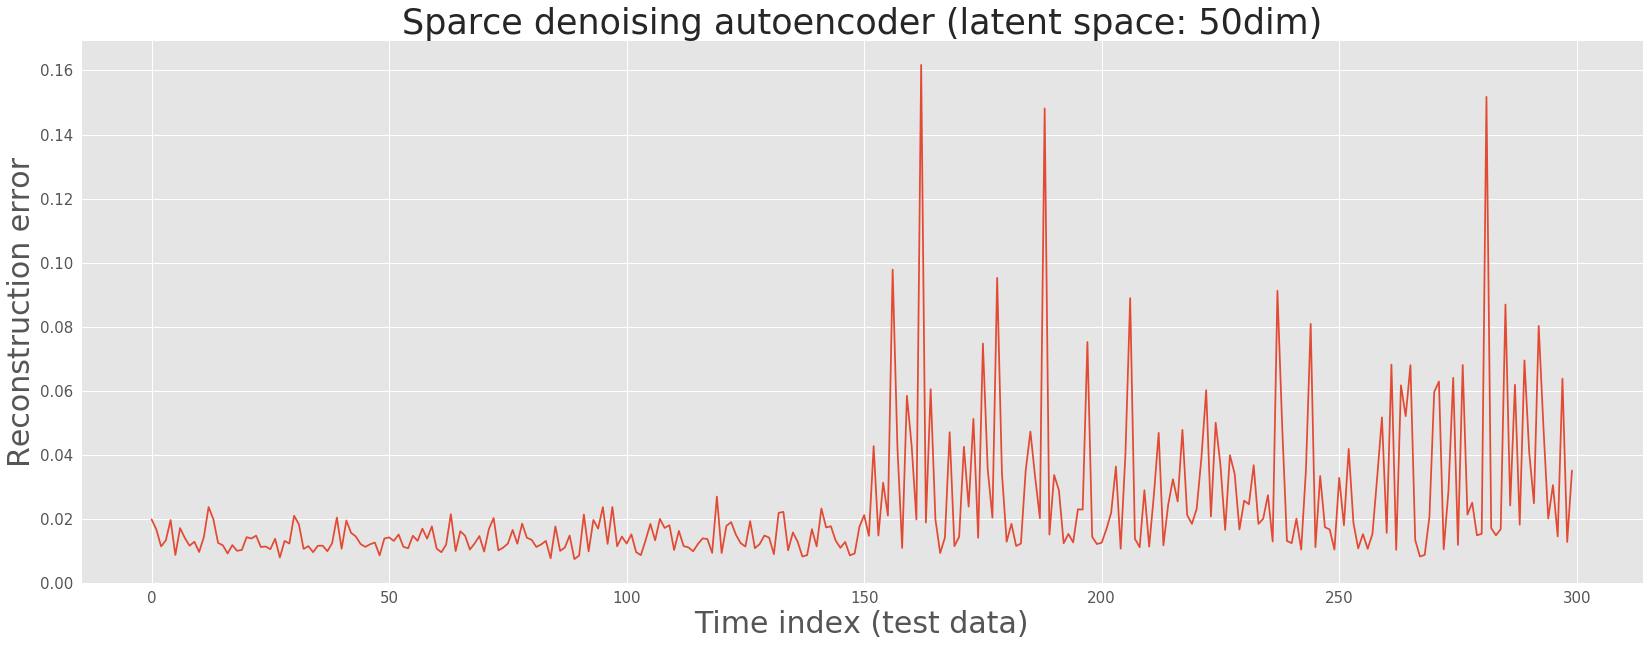

In [47]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    plt.plot(AE_denoising.get_error_recustruction_test())
    plt.title('Sparce denoising autoencoder (latent space: 50dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Reconstruction error', size=30)

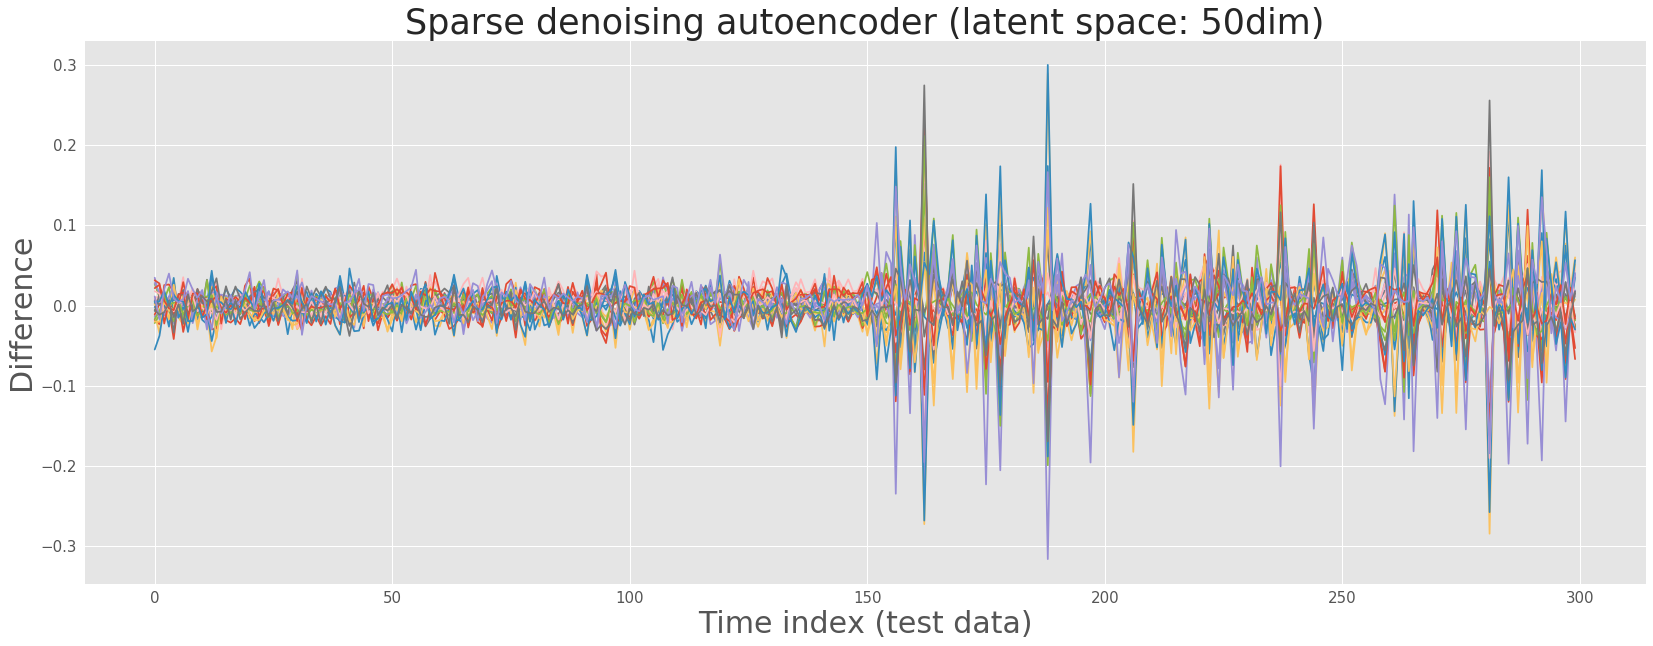

In [48]:
X = AE_denoising.X_test_hat.T
with plt.style.context('ggplot'):
    plt.figure(figsize=(28,10))
    for i in np.arange(0,25):
        plt.plot(np.arange(300), X_test.T[i,:]-X[i,:])
    plt.title('Sparse denoising autoencoder (latent space: 50dim)', size=35)
    plt.xlabel('Time index (test data)', size=30)
    plt.ylabel('Difference', size=30)

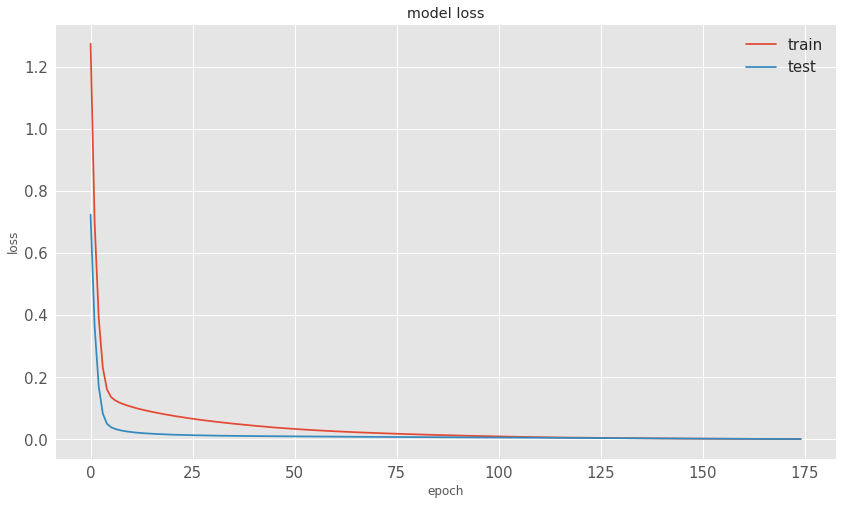

In [49]:
with plt.style.context('ggplot'):
    plt.plot(history_denoising['loss'])
    plt.plot(history_denoising['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

In [50]:
rmse_AED = AE_denoising.get_error_recustruction_test()
error_df_AED = pd.DataFrame({'reconstruction_error': rmse_AED,
                        'true_class': y_test})
error_df_AED.describe()

reconstruction_error  true_class
count            300.000000  300.000000
mean               0.023686    0.500000
std                0.021756    0.500835
min                0.007530    0.000000
25%                0.012012    0.000000
50%                0.015381    0.500000
75%                0.023816    1.000000
max                0.161716    1.000000

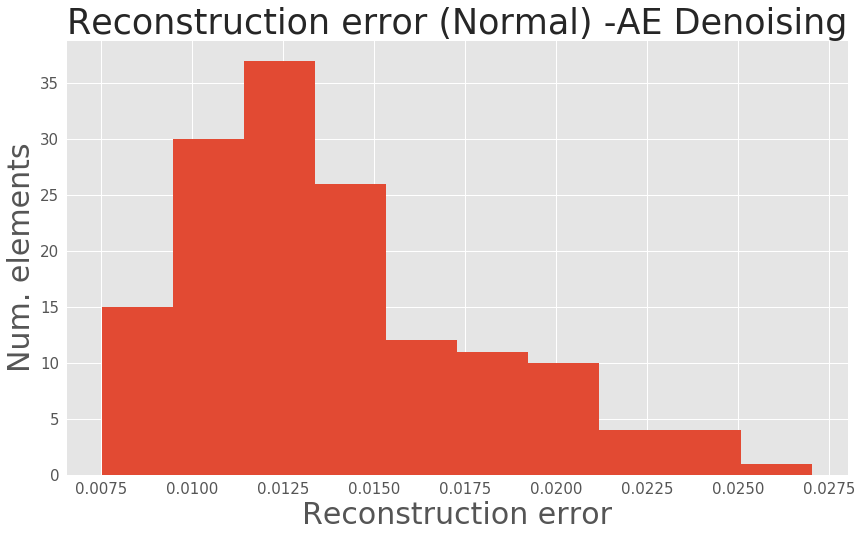

In [51]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    normal_error_df_AED = error_df_AED[(error_df_AED['true_class']== 0) & (error_df_AED['reconstruction_error'] < 10)]
    _ = ax.hist(normal_error_df_AED.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Normal) -AE Denoising', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

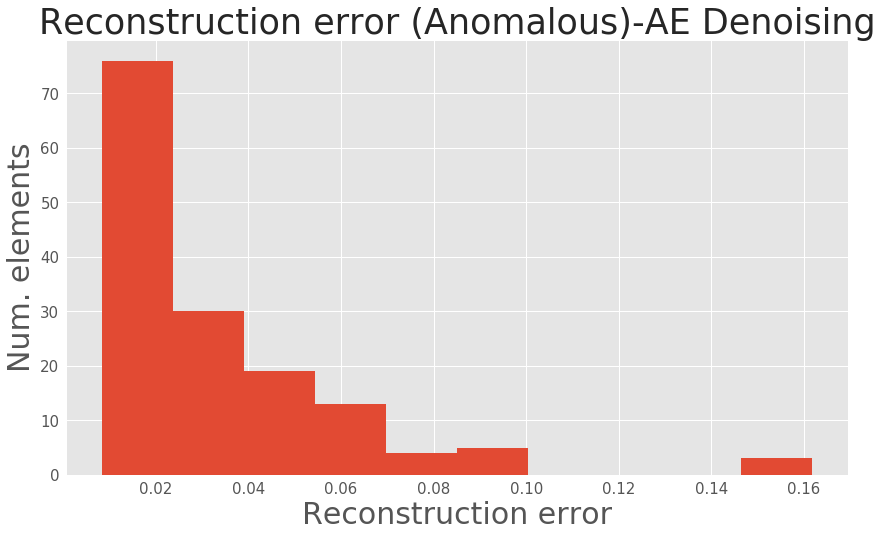

In [52]:
with plt.style.context('ggplot'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fraud_error_df_AED = error_df_AED[error_df_AED['true_class'] == 1]
    _ = ax.hist(fraud_error_df_AED.reconstruction_error.values, bins=10)
    plt.title('Reconstruction error (Anomalous)-AE Denoising', size=35)
    plt.xlabel('Reconstruction error', size=30)
    plt.ylabel('Num. elements', size=30)

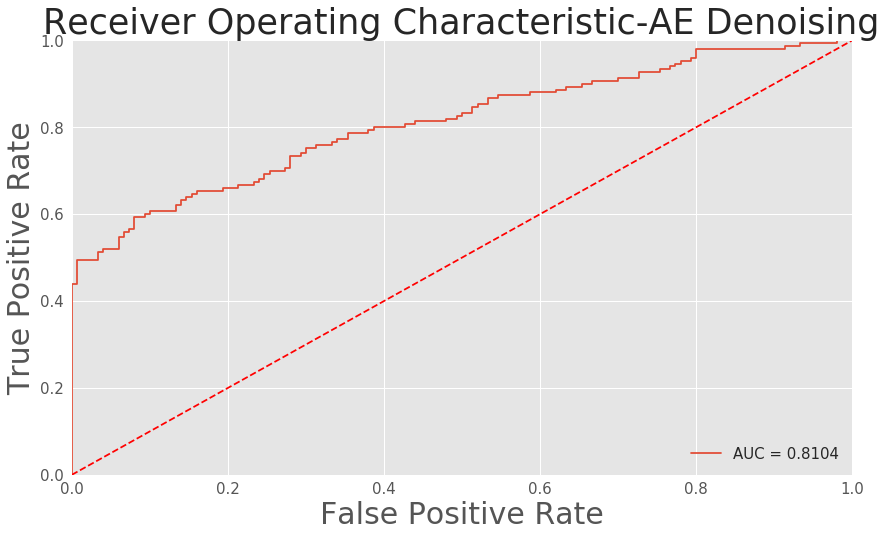

In [53]:
fpr_AED, tpr_AED, thresholds_AED = roc_curve(error_df_AED.true_class, error_df_AED.reconstruction_error)
roc_auc_AED = auc(fpr_AED, tpr_AED)
with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic-AE Denoising', size = 35)
    plt.plot(fpr_AED, tpr_AED, label='AUC = %0.4f'% roc_auc_AED)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size = 30)
    plt.xlabel('False Positive Rate', size = 30)

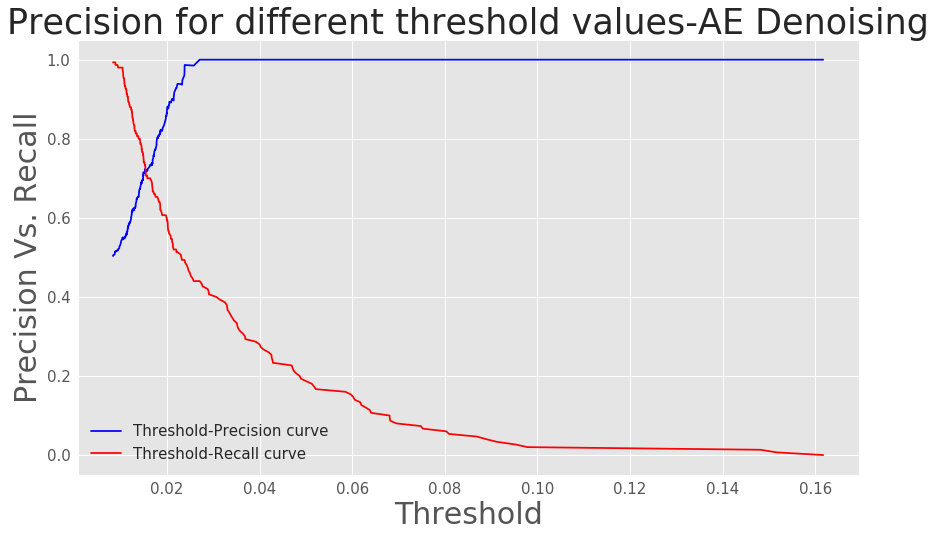

In [54]:
precision_AED, recall_AED, th_AED = precision_recall_curve(error_df_AED.true_class, error_df_AED.reconstruction_error)
with plt.style.context('ggplot'):
    plt.plot(th_AED, precision_AED[1:], 'b', label='Threshold-Precision curve')
    plt.plot(th_AED, recall_AED[1:], 'r', label='Threshold-Recall curve')
    plt.title('Precision for different threshold values-AE Denoising', size = 35)
    plt.xlabel('Threshold', size = 30)
    plt.ylabel('Precision Vs. Recall', size = 30)
    plt.legend(loc='best')

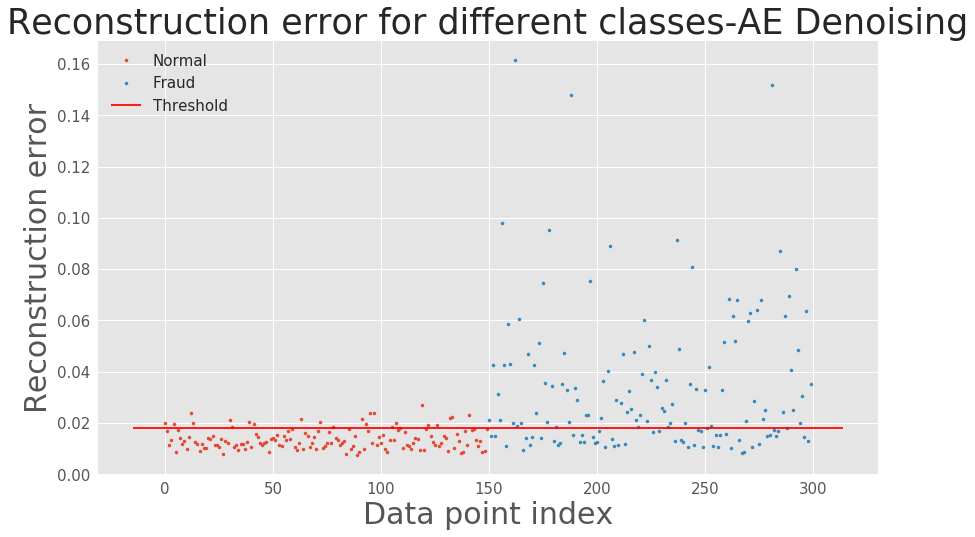

In [55]:
threshold = 0.018
with plt.style.context('ggplot'):
    groups_AED = error_df_AED.groupby('true_class')
    fig, ax = plt.subplots()

    for name, group in groups_AED:
        ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
                label= "Fraud" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes-AE Denoising", size = 35)
    plt.ylabel("Reconstruction error", size = 30)
    plt.xlabel("Data point index", size = 30)


Text(0.5, 82.0, 'Predicted class')

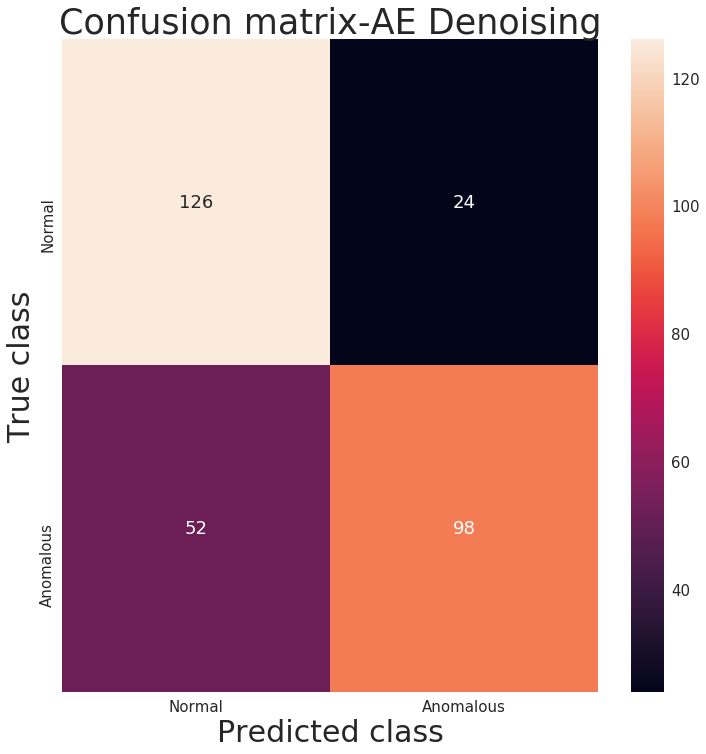

In [56]:
y_pred_AED = [1 if e > threshold else 0 for e in error_df_AED.reconstruction_error.values]
conf_matrix_AED = confusion_matrix(error_df_AED.true_class, y_pred_AED)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix_AED, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix-AE Denoising", size = 35)
plt.ylabel('True class', size = 30 )
plt.xlabel('Predicted class', size = 30)


# ROC finale

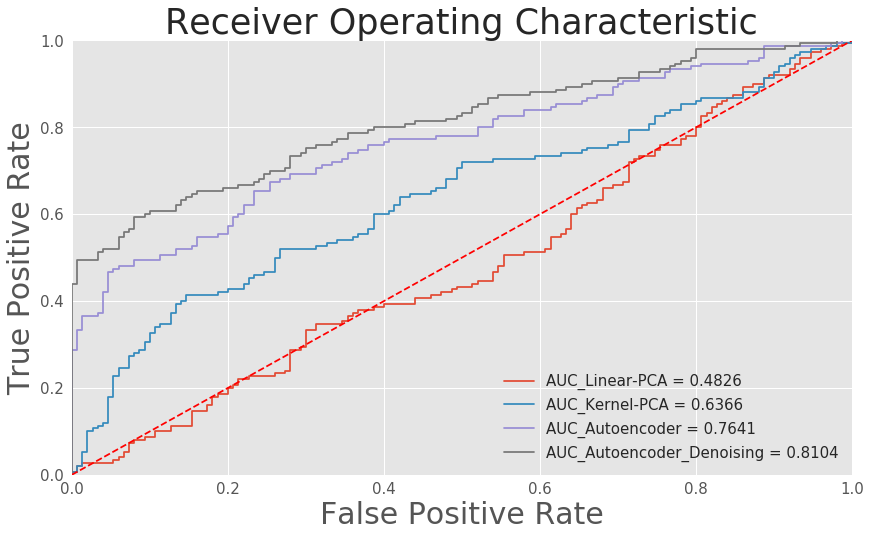

In [57]:
fpr_pca, tpr_pca, thresholds_pca = roc_curve(error_df_pca.true_class, error_df_pca.reconstruction_error)
roc_auc_pca = auc(fpr_pca, tpr_pca)
with plt.style.context('ggplot'):
    plt.title('Receiver Operating Characteristic', size=35)
    plt.plot(fpr_pca, tpr_pca, label='AUC_Linear-PCA = %0.4f'% roc_auc_pca)
    plt.plot(fpr_kpca, tpr_kpca, label='AUC_Kernel-PCA = %0.4f'% roc_auc_kpca)
    plt.plot(fpr_AE, tpr_AE, label='AUC_Autoencoder = %0.4f'% roc_auc_AE)
    plt.plot(fpr_AED, tpr_AED, label='AUC_Autoencoder_Denoising = %0.4f'% roc_auc_AED)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate', size=30)
    plt.xlabel('False Positive Rate', size=30)

## Analisi dei risultati: errore di costruzione, curva roc e matrice di confusione

Dai grafici dell'errore di costruzione possiamo osservare che su questi dati la **PCA** non è in grado di distinguere i dati anomali da quelli normali, infatti l'andamento dell'errore di costruzione è alto per tutti i dati e lo stesso vale per la differenza tra le time series originali e quelle ricostruite.
Dal grafico che mette in relazione la precison e recall della PCA, risulta che il valore ottimale di threshold è $0.4x10^{-15}$, ma questo non produce risultati desiderati: riconosce poche anomalie e riconosce molti dati normali come anomalie.<br>
Per la **Kernel PCA** si ha un miglioramento, infatti osservando l'andamento dell'errore di ricostruzione possiamo osservare che i primi 130 dati hanno un errore di ricostruione basso mentre quelli da 130 in poi hanno un errore alto, infatti questi dati sono anomali.<br>
Dal grafico che mette in relazione la precison e recall della kernel PCA, risulta che il valore ottimale di threshold è $0.1$. Al contrario della PCA lineare molti dati normali sono riconosciuti come tali e lo stesso per gli anomali, ma è presente un elavato tasso di falsi postivi e negativi che non può essere ignorato.<br>
Per l' **autoencoder sparso** possiamo osservare che l'andamento dell'errore di costruzione per i primi 150 dati è molto basso mentre per quelli successivi, in cui sono presenti dati anomali, l'errore di ricostruzione è molto grande; lo stesso si ripercuote sulla differenza delle time series originali e ricostruite, a sinistra di 150 la differenza è piccola, a destra la differenza è molto grande.<br>
Dal grafico che mette in relazione la precison e recall dell'autoencoder sparso, risulta che il valore ottimale di threshold è $0.06$ e osservando la matrice di confusione possiamo notare una simmetria tra il riconoscimento dei dati normali e quelli anomali.<br>
Infine per il **denoising autoencoder** valgono le stesse considerazioni fatte per l'autoencoder sparso per quanto riguarda l'analisi dell'errore di ricostruzione.<br>
La threshold per il denoising autoencoder è 0.018, questa volta il riconoscimento dei dati anomali è più efficiente in quanto la maggior parte dei dati normali viene riconosciuto come tale e meno del 25% dei normali viene identificato come anomalo, mentre per le anomalie il 65% viene riconosciuto come tale e il 35% delle anomalie vengono identificate come dati normali.<br>

La **curva ROC finale** mostra il rapporto tra i veri positivi e i falsi positivi al variare della threshold, per ciascuno degli algoritmi adottatati. In generale possiamo osservare che le tecniche non lineari hanno dato buoni risultati, e il Denoising Autoencoder è quello con prestazioni migliori.<br>


## Riferimenti

[1] M. Sakurada and T. Yairi, *Anomaly Detection Using Autoencoders with Nonlinear Dimensionality Reduction*, 2014 ACM